Responsabilidades:
- Simular la respuesta al escalón de Gcl(s) con los valores hallados.
- Implementar el PID en el script de TempLABUdeA.
- Realizar la prueba práctica, recolectar los datos de temperatura y control.
- Comparar los datos experimentales con la simulación (gráficas, %OS, Ts).

Entregables:
- Código de simulación y control.
- Archivos CSV de los datos experimentales.
- Gráficas comparativas: simulación vs experimento.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import ipywidgets as widgets
from ipywidgets import interact

## Simulacion de la respuesta al escalón de Gcl(s).

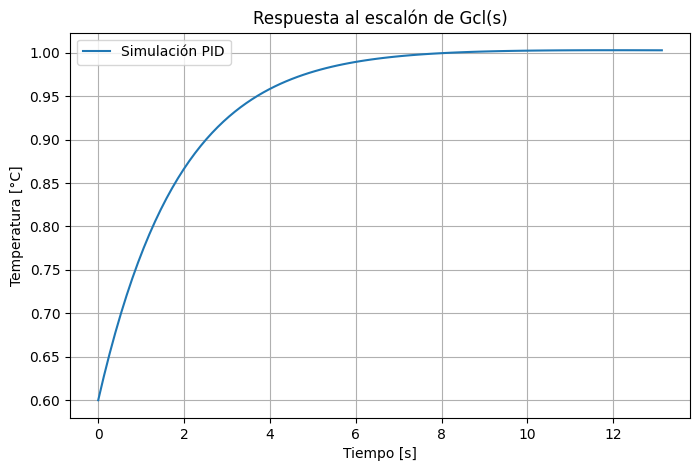


Parámetros:
RiseTime : 2.520819626701714
SettlingTime : 5.174313970598255
SettlingMin : 0.9003852667694816
SettlingMax : 1.0027286753095408
Overshoot : 0.27286753095407956
Undershoot : 0
Peak : 1.0027286753095408
PeakTime : 11.940724547534433
SteadyStateValue : 1.0


In [6]:
K = 0.3
tau = 10
Kp = 50
Ti = tau
Td = tau / 10
L =ctl.tf([Kp*K*Ti*Td, Kp*K*Ti, Kp*K],[Ti*tau, Ti, 0])
Gcl = ctl.feedback(L, 1)
t, y = ctl.step_response(Gcl)

plt.figure(figsize=(8, 5))
plt.plot(t, y, label='Simulación PID')
plt.title('Respuesta al escalón de Gcl(s)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

S2 = ctl.step_info(Gcl)
print("\nParámetros:")
for i in S2:
  print(i,":",S2[i])

## Implementación en TempLABUdeA y recolectar datos.

In [ ]:
import tclab 
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# ------------------------------------------------------------------------------
# Función para permitir seleccionar el tipo de controlador
def ejecutar_control(tipo_controlador='PID'):
    """
    Ejecuta el control de temperatura con el tipo de controlador seleccionado
    tipo_controlador: 'PD', 'PI', o 'PID'
    """
    lab = tclab.TCLab()
    
    # Parámetros de control
    Kc = 62.4  # Ganancia proporcional
    tauI = 18.9295  # Tiempo integral
    tauD = 4.7324  # Tiempo derivativo
    Q_bias = 0.0  # Bias
    ierr = 0.0  # Error integral acumulado
    prev_err = 0.0  # Error anterior (para término derivativo)
    
    # Inicializar listas
    n = 600  # Número de muestras
    T1 = [0.0] * n  # Temperatura en sensor 1
    T2 = [0.0] * n  # Temperatura en sensor 2
    Q1 = [0.0] * n  # Señal de control para calentador 1
    SP1 = [40.0] * n  # Setpoint (temperatura deseada)
    
    # Para almacenar los componentes del controladors
    P_component = [0.0] * n  # Componente proporcional
    I_component = [0.0] * n  # Componente integral
    D_component = [0.0] * n  # Componente derivativo
    
    # Configurar la gráfica en modo interactivo
    plt.ion()
    
    try:
        print(f"Iniciando control {tipo_controlador}...")
        for i in range(n):
            # Leer temperatura actual
            T1[i] = lab.T2
            T2[i] = lab.T1
            
            # Cálculo del error
            err = SP1[i] - T1[i]
            
            # Componente proporcional - siempre se usa
            P_component[i] = Kc * err
            
            # Componente integral - solo para PI y PID
            if tipo_controlador in ['PI', 'PID']:
                ierr += err
                I_component[i] = (Kc / tauI) * ierr
            
            # Componente derivativo - para PD y PID
            if tipo_controlador in ['PD', 'PID']:
                deriv = (err - prev_err)
                D_component[i] = Kc * tauD * deriv
                prev_err = err
            
            # Calcular la acción de control según el tipo de controlador
            if tipo_controlador == 'PD':
                Q1[i] = Q_bias + P_component[i] + D_component[i]
            elif tipo_controlador == 'PI':
                Q1[i] = Q_bias + P_component[i] + I_component[i]
            else:  # PID
                Q1[i] = Q_bias + P_component[i] + I_component[i] + D_component[i]
            
            # Anti-windup
            if Q1[i] >= 100:
                Q1[i] = 100
                if tipo_controlador in ['PI', 'PID']:
                    ierr -= err  # Corregir el error integral acumulado
            elif Q1[i] <= 0:
                Q1[i] = 0
                if tipo_controlador in ['PI', 'PID']:
                    ierr -= err  # Corregir el error integral acumulado
            
            # Aplicar señal de control
            if i > 10:
                lab.Q1(Q1[i])
            else:
                Q1[i] = 0.0
                lab.Q1(0)
            
            # Para actualizar cada 10 segundos pero seguir muestreando cada segundo:
            # 1. Solo actualizamos la gráfica cada 10 iteraciones
            # 2. Pero seguimos tomando muestras y aplicando control cada iteración
            
            if i % 10 == 0 or i == n-1:  # Actualizar gráfica cada 10 segundos o en la última iteración
                # Gráfica de temperatura
                plt.clf()
                plt.subplot(2, 1, 1)
                plt.plot(T1[:i+1], 'r-o', label='T1')
                plt.plot(T2[:i+1], 'b-o', label='T2')
                plt.plot(SP1[:i+1], 'k--', label='SP')
                plt.ylabel('Temperatura (°C)')
                plt.title(f'Control {tipo_controlador} de Temperatura')
                plt.grid(True)
                plt.legend()
                
                # Gráfica de PWM (Q1)
                plt.subplot(2, 1, 2)
                plt.plot(Q1[:i+1], 'b-', label='Q1 (PWM)')
                
                # También graficar los componentes del controlador
                plt.plot(P_component[:i+1], 'g-', label='P')
                
                if tipo_controlador in ['PD', 'PID']:
                    plt.plot(D_component[:i+1], 'c-', label='D')
                    
                if tipo_controlador in ['PI', 'PID']:
                    plt.plot(I_component[:i+1], 'y-', label='I')
                
                plt.ylabel('PWM (%)')
                plt.title('Señal de control Q1')
                plt.xlabel('Tiempo (s)')
                plt.grid(True)
                plt.legend()
                
                plt.tight_layout()
                plt.pause(0.05)  # Pequeña pausa necesaria para actualizar la gráfica
                print(f"Iteración {i}: T1={T1[i]:.2f}°C, Q1={Q1[i]:.2f}%")
                
            time.sleep(1)  # Esperar un segundo entre muestras
        
    except KeyboardInterrupt:
        # En caso de interrupción, apagar y cerrar conexión
        print("\nDetención por usuario. Apagando calentadores y cerrando conexión.")
    
    finally:
        # Asegurar que siempre se apaguen los calentadores y se cierre la conexión
        lab.Q1(0)
        lab.Q2(0)
        lab.close()
        
        # Guardar resultados
        t = np.arange(n)
        
        # Crear DataFrame con los datos
        data = {
            'Tiempo (s)': t,
            'Setpoint (SP)': SP1,
            'Temperatura (T1)': T1,
            'Control PWM (Q1)': Q1,
            'Componente P': P_component
        }
        
        # Añadir componentes según el controlador usado
        if tipo_controlador in ['PD', 'PID']:
            data['Componente D'] = D_component
        if tipo_controlador in ['PI', 'PID']:
            data['Componente I'] = I_component
        
        df = pd.DataFrame(data)
        
        # Generar timestamp para nombrar los archivos
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        
        # Guardar datos en CSV
        csv_filename = f'registro_{tipo_controlador}_TempLab_{timestamp}.csv'
        df.to_csv(csv_filename, index=False)
        print(f"Datos guardados en '{csv_filename}'")
        
        # Crear gráfica final para guardar como imagen
        plt.figure(figsize=(12, 8))
        
        # Gráfica 1: Temperatura vs Tiempo
        plt.subplot(3, 1, 1)
        plt.plot(t, T1, 'r-', label='T1')
        plt.plot(t, SP1, 'k--', label='SP')
        plt.ylabel('Temperatura (°C)')
        plt.title(f'Control {tipo_controlador} de Temperatura')
        plt.grid(True)
        plt.legend()
        
        # Gráfica 2: Señal de control (PWM) vs Tiempo
        plt.subplot(3, 1, 2)
        plt.plot(t, Q1, 'b-', label='Q1 (PWM)')
        plt.ylabel('PWM (%)')
        plt.title('Señal de control Q1')
        plt.grid(True)
        plt.legend()
        
        # Gráfica 3: Componentes del controlador vs Tiempo
        plt.subplot(3, 1, 3)
        plt.plot(t, P_component, 'g-', label='P')
        if tipo_controlador in ['PD', 'PID']:
            plt.plot(t, D_component, 'c-', label='D')
        if tipo_controlador in ['PI', 'PID']:
            plt.plot(t, I_component, 'y-', label='I')
        plt.ylabel('Magnitud de componentes (%)')
        plt.xlabel('Tiempo (s)')
        plt.title('Componentes del controlador')
        plt.grid(True)
        plt.legend()
        
        # Guardar imagen
        image_filename = f'grafico_{tipo_controlador}_TempLab_{timestamp}.png'
        plt.tight_layout()
        plt.savefig(image_filename)
        print(f"Gráfica guardada en '{image_filename}'")
        
        plt.ioff()  # Desactivar modo interactivo
        plt.show()  # Mostrar la gráfica final
        
        return df  # Retornar el dataframe con los resultados

# Ejemplo de uso:
if __name__ == "__main__":
    print("Selecciona el tipo de controlador:")
    print("1 - Control Proporcional-Derivativo (PD)")
    print("2 - Control Proporcional-Integral (PI)")
    print("3 - Control Proporcional-Integral-Derivativo (PID)")
    
    opcion = input("Ingresa el número de la opción deseada (1, 2 o 3): ")
    
    if opcion == '1':
        ejecutar_control('PD')
    elif opcion == '2':
        ejecutar_control('PI')
    elif opcion == '3':
        ejecutar_control('PID')
    else:
        print("Opción no válida. Ejecutando PID por defecto.")
        ejecutar_control('PID')

## Archivo de datos experimentales (*.csv)

In [ ]:
import pandas as pd

# Cargar datos experimentales
df = pd.read_csv("datos_experimentales.csv")

# Graficar comparación
plt.figure(figsize=(9, 5))
plt.plot(t, y, label="Simulación")
plt.plot(df["Tiempo"], df["T1"], label="Experimento")
plt.xlabel("Tiempo [s]")
plt.ylabel("Temperatura [°C]")
plt.title("Comparación: Simulación vs Experimento")
plt.grid(True)
plt.legend()
plt.show()